In [46]:
# Some useful settings for interactive work
%load_ext autoreload
%autoreload 2

%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
# Import the relevant modules
import sousvide.synthesize.rollout_generator as rg
import sousvide.synthesize.observation_generator as og
import sousvide.instruct.train_policy as tp
import sousvide.visualize.plot_synthesize as ps
import sousvide.visualize.plot_learning as pl
import sousvide.flight.deploy_figs as df

In [48]:
cohort = "forces"             # cohort name

data_methods = [
    "data_beta_f0",                  # method name
    "data_beta_f1",
    "data_beta_f2",
    "data_beta_f3",
    "data_beta_f4",
    "data_beta_f5",
]

scene = "mid_gate"                  # scene name

courses = [                         # course names
    # "hover",
    "line",
    # "robustness_track"
    ]   

roster = [
    "Maverick",                     # sifu_testbed
    ]

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/mid_gate/splatfacto/2024-10-07_145741/nerfstudio_models/step-000029999.ckpt

Output()

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/mid_gate/splatfacto/2024-10-07_145741/nerfstudio_models/step-000029999.ckpt

Output()

Only 1 samples available in [line_eval_single_f5b]>trajectories001.pt. Showing all samples.

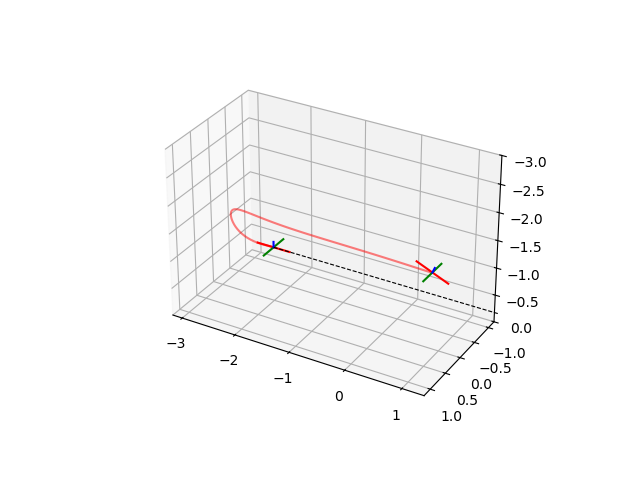

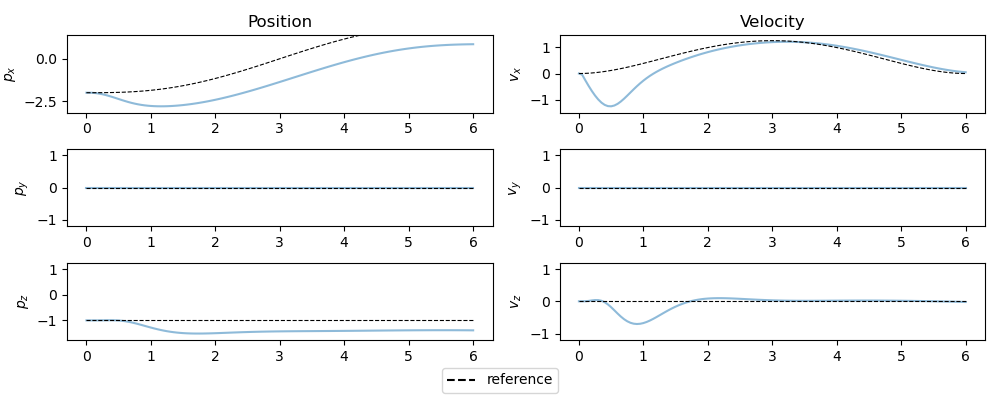

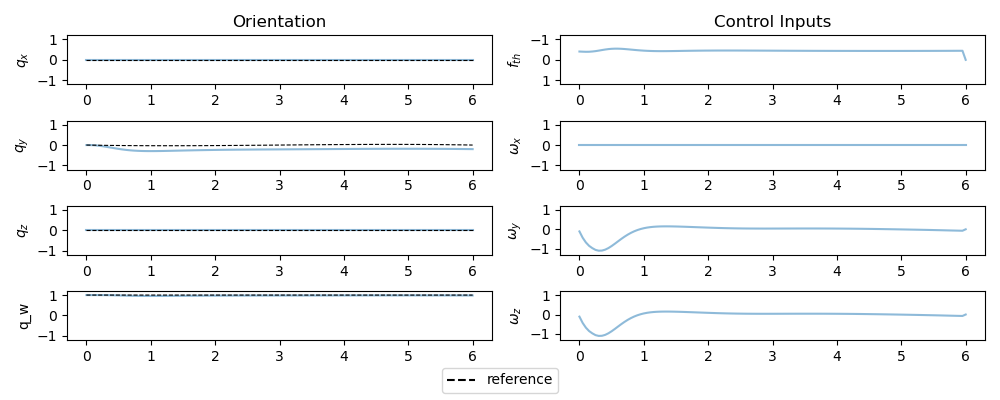

Showing 1 samples from [line_eval_single_f5]>trajectories001.pt

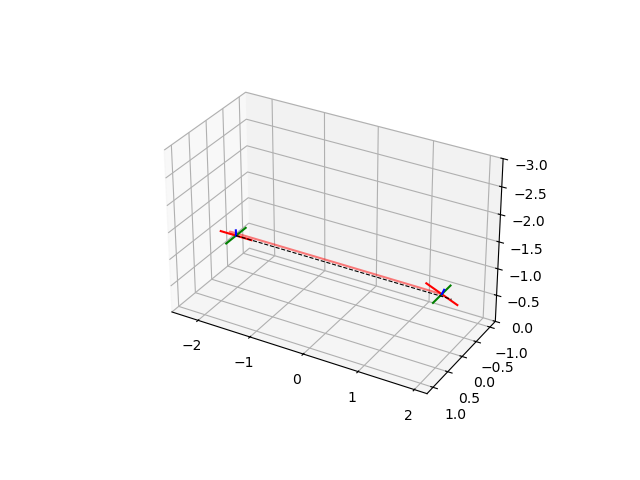

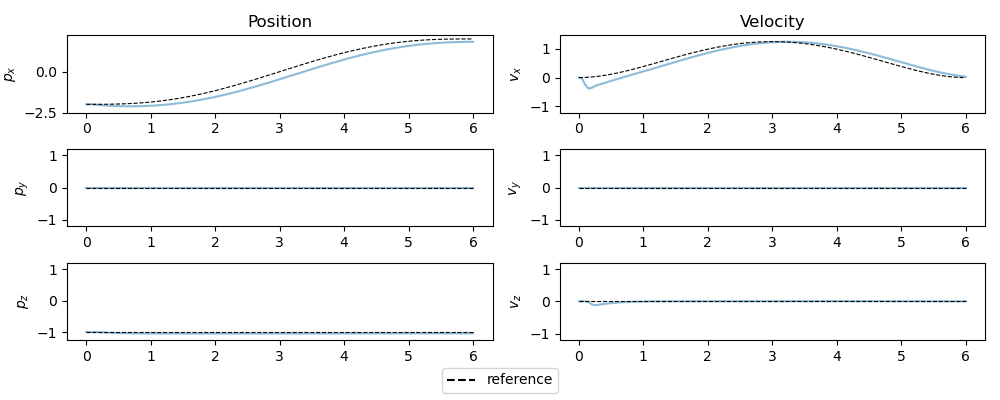

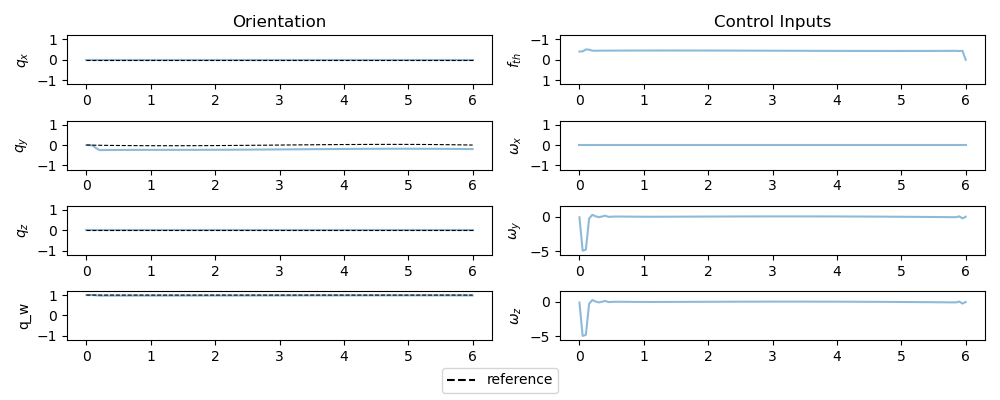

Rollout produced 2 datasets with the following courses: 
line_eval_single_f5b( 120 dpts) [1 datasets]
line_eval_single_f5( 120 dpts) [1 datasets]

In [ ]:
# Generate Rollouts
for data_method in data_methods:
    rg.generate_rollout_data(cohort,courses,scene,data_method,
                             expert_name="vrmpc_fe")
    
# Review the Rollout Data
ps.plot_rollout_data(cohort)

In [10]:
import numpy as np
from scipy.spatial.transform import Rotation as R
import os
import torch
import figs.visualize.generate_videos as gv

K = np.array([
    [ 462.956,   0.000, 323.076],
    [   0.000, 463.002, 181.184],
    [   0.000,   0.000,   1.000]
])
Tcm2cr = np.array([
    [ 0.00000,  0.00000, -1.00000,  0.10000],
    [ 1.00000,  0.00000,  0.00000, -0.03000],
    [ 0.00000, -1.00000,  0.00000, -0.01000],
    [ 0.00000,  0.00000,  0.00000,  1.00000]
])
Tcr2cm = np.linalg.inv(Tcm2cr)
Rgl2cv = np.array([
    [ 1.0, 0.0, 0.0],
    [ 0.0,-1.0, 0.0],
    [ 0.0, 0.0,-1.0]
])

def pose2proj(xcr,Xds,nb=20):
    # Goal Frame to World Frame
    Pds = Xds[0:3,:]
    Pds = np.vstack((Pds,np.ones((1,Pds.shape[1]))))

    # World Frame to Current Frame
    Twd2cr = np.eye(4)
    Twd2cr[0:3,0:3] = R.from_quat(xcr[6:10]).as_matrix().T
    Twd2cr[0:3,3] = -Twd2cr[0:3,0:3]@xcr[0:3]

    # Positions in camera frame
    Pcm = Tcr2cm@Twd2cr@Pds
    Pcm = Pcm[0:3,:]

    # Switch to OpenCV convention
    Pcm = Rgl2cv@Pcm

    # Project to Image Plane
    Ppr = K@Pcm

    # Normalize by z
    width  = Ppr[0,:]/(Ppr[2,:])
    height = Ppr[1,:]/(Ppr[2,:])

    # Clip to image size
    width = np.clip(width,0+nb,640-nb)
    height = np.clip(height,0+nb,360-nb)

    # Package
    UV = np.vstack((width,height))
    UV = UV.astype(int)
    
    return UV

def pose2line(xcr,xds):
    Nl = 10
    Lds_cr = np.zeros((3,Nl))
    Lds_cr[1,:] = np.linspace(-0.1,0.1,Nl)

    tds_wd = xds[0:3]
    Rds2wd = R.from_quat(xds[6:10]).as_matrix()

    Lds_wd = Rds2wd@Lds_cr + tds_wd[:,np.newaxis]

    Width,Height = pose2proj(xcr,Lds_wd)

    return Width,Height

def pose2edges(xcr,xds,z_gain=1.0):
    Lds_cr = np.array([
        [ 0.0, 0.0],
        [-0.1, 0.1],
        [ 0.0, 0.0]
    ])

    tds_wd = xds[0:3]
    Rds2wd = R.from_quat(xds[6:10]).as_matrix()

    Lds_wd = Rds2wd@Lds_cr + tds_wd[:,np.newaxis]

    UV = pose2proj(xcr,Lds_wd,z_gain)

    return UV

def get_patch_index(u,v, patch_height, patch_width, n_rows, n_cols):

    row = int(v / patch_height)
    col = int(u / patch_width)

    # Clamp to valid index range
    row = min(max(row, 0), n_rows - 1)
    col = min(max(col, 0), n_cols - 1)

    return row, col

def get_patch_bounds(u,v, H, W, n_rows, n_cols):
    patch_height = H / n_rows
    patch_width = W / n_cols

    row,col = get_patch_index(u,v, patch_height, patch_width, n_rows, n_cols)

    top = int(round(row * patch_height))
    bottom = int(round((row + 1) * patch_height))
    left = int(round(col * patch_width))
    right = int(round((col + 1) * patch_width))

    return [top, bottom, left, right]

In [12]:
# Load Trajectories
# course_directory = os.path.join("..","cohorts",cohort,"rollout_data","robustness_track")
# course_directory = os.path.join("..","cohorts",cohort,"rollout_data","line_eval_single")
# course_directory = os.path.join("..","cohorts",cohort,"rollout_data","line_eval_single_f1")
# course_directory = os.path.join("..","cohorts",cohort,"rollout_data","line_eval_single_f2")
# course_directory = os.path.join("..","cohorts",cohort,"rollout_data","line_eval_single_f3")
# course_directory = os.path.join("..","cohorts",cohort,"rollout_data","line_eval_single_f4")
course_directory = os.path.join("..","cohorts",cohort,"rollout_data","line_eval_single_f5")

Trajectories = torch.load(os.path.join(course_directory,"trajectories","trajectories001.pt"))
Images = torch.load(os.path.join(course_directory,"images","images001.pt"))

trajectories = Trajectories[0]
images = Images[0]

Tro,Xro,tXd = trajectories["Tro"],trajectories["Xro"],trajectories["tXd"]

Nro = len(Tro)

In [13]:
Iro = 1*images["images"]

height,width = Iro.shape[1],Iro.shape[2]
n_rows,n_cols = 64,64

nb = 5
dini,dst,nst = 10,5,10
Nst = dst*nst
clr = int(255/nst)
for i in range(Nro-1):
    idx_rf = np.arange(i+dini+dst,i+Nst+dini+1,dst)
    idx_rf = np.clip(idx_rf,0,Nro-1)
    Xrf = Xro[:,idx_rf]

    UV = []
    for j in range(nst):
        UV.append(pose2edges(Xro[:,i], Xrf[:,j]))
    UV = np.hstack(UV)

    for j in range(UV.shape[1]):
        idx = j//2
        u,v = UV[0,j],UV[1,j]
        bnds = get_patch_bounds(u,v,height,width,n_rows,n_cols)

        Iro[i,bnds[0]:bnds[1],bnds[2]:bnds[3],:] = 0
        Iro[i,bnds[0]:bnds[1],bnds[2]:bnds[3],1] = 255
        Iro[i,bnds[0]:bnds[1],bnds[2]:bnds[3],2] = idx*clr
#     for k in range(Width.shape[0]):
#         width = np.clip(Width[k],1,639)
#         height = np.clip(Height[k],1,359)

#         Iro[i,height-nb:height+nb,width-nb:width+nb,:] = 0
#         Iro[i,height-nb:height+nb,width-nb:width+nb,1] = 255

gv.images_to_mp4(Iro,'output.mp4', 20)


In [ ]:
nft,nb = 20,2
Nres,Nro = 100,

# Extract future poses
ob = np.zeros((4,1))
xb = np.zeros((4,Nres))
yb = np.zeros((4,Nres))
zb = np.zeros((4,Nres))
xb[0,:] = np.linspace(0.0,0.3,Nres)
yb[1,:] = np.linspace(0.0,0.3,Nres)
zb[2,:] = np.linspace(0.0,0.1,Nres)
xb[3,:],yb[3,:],zb[3,:] = 1.0,1.0,1.0

rinit = [xb,yb,zb]
for i in range(Nro):
    # Get index
    g = np.min([i+nft,len(Tro)-1])

    # Goal Frame to World Frame
    Tg2w = np.eye(4)
    Tg2w[0:3,0:3] = R.from_quat(Xro[6:10,g]).as_matrix()
    Tg2w[0:3,3] = Xro[0:3,g]

    # World Frame to Current Frame
    Tw2i = np.eye(4)
    Tw2i[0:3,0:3] = R.from_quat(Xro[6:10,i]).as_matrix().T
    Tw2i[0:3,3] = -Tw2i[0:3,0:3]@Xro[0:3,i]

    refs = []
    for idx,rg in enumerate(rinit):
        # Position in camera frame
        rc = Ti2c@Tw2i@Tg2w@rg
        rc = rc[0:3,:]

        # Switch to OpenCV convention
        rc = Rgl2cv@rc

        # Project to Image Plane
        r_pr = K@rc
        # Append to list
        refs.append(r_pr)

    # Handle Reference Arrows
    for j in range(Nres):
        for k in range(3):
            z = refs[k][2,j]
            width  = int(refs[k][0,j]/z)
            height = int(refs[k][1,j]/z)

            if z > 0 and width > 0 and width < 640 and height > 0 and height < 360:
                Iro[i,height-nb:height+nb,width-nb:width+nb,:] = 0
                Iro[i,height-nb:height+nb,width-nb:width+nb,k] = 255

gv.images_to_mp4(Iro,'output.mp4', 20)
